In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils_new import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_WGAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [32]:
#WGAN params###
c = 0.01
n_critic = 5
####
lr = 0.00005
prior_size = 100
train_epoch = 1000
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))

In [33]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [34]:
G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28, 1024, 512, 256, 1], activation_fn=nn.LeakyReLU(0.2), flatten=True) #dropout=0.3, )

#G_optimizer = optim.Adam(G.parameters(), lr=lr)
#D_optimizer = optim.Adam(D.parameters(), lr=lr)
G_optimizer = optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

In [35]:
G.parameters

<bound method Module.parameters of FullyConnected(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)>

In [36]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [37]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [63]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z))
        true_pred = D(data)
        #print()
        
        # Original GAN
        #fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        #true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        #D_loss = 0.5*(fake_loss + true_loss)
        D_loss = -torch.mean(true_pred) + torch.mean(fake_pred)
        #print(batch_idx)
        #print(true_pred)
        #print(torch.mean(true_pred))
        #print(D_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(-c, c)
            #print(p.data)
        
        # train G
        if batch_idx % n_critic == 0:
            #print(batch_idx)
            D.zero_grad()
            G.zero_grad()
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z))
            # Original GAN
            #G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
            G_loss = -torch.mean(fake_pred) 
            G_loss.backward()
            G_optimizer.step()
            ####

            
        if batch_idx % 100 == 0:
            #print('test')
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
               epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        #print('test2')
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [64]:
for param in D.named_parameters():
  print(param)

('model.0.weight', Parameter containing:
tensor([[-0.0082, -0.0082, -0.0082,  ..., -0.0082, -0.0082, -0.0082],
        [-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100],
        ...,
        [-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100],
        [-0.0082, -0.0082, -0.0082,  ..., -0.0082, -0.0082, -0.0082],
        [-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100]],
       requires_grad=True))
('model.0.bias', Parameter containing:
tensor([0.0082, 0.0100, 0.0100,  ..., 0.0100, 0.0082, 0.0100],
       requires_grad=True))
('model.2.weight', Parameter containing:
tensor([[-0.0009,  0.0100,  0.0100,  ...,  0.0100, -0.0009,  0.0100],
        [-0.0009,  0.0100,  0.0100,  ...,  0.0100, -0.0009,  0.0100],
        [-0.0009,  0.0100,  0.0100,  ...,  0.0100, -0.0009,  0.0100],
        ...,
        [ 0.0100, -0.0100, -0.0100,  ..., -0.0100,  0.0100, -0.0100],
        [-0.0009,  0.0100,  0.010

In [65]:
# подкорректировать
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z))
            true_pred = D(data)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

In [68]:
# подкорректировать
def test_wg(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z))
            true_pred = D(data)
        
            #fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            #true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            D_loss = -torch.mean(true_pred) + torch.mean(fake_pred)
            #D_loss += 0.5*(fake_loss + true_loss)
            #G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            G_loss = -torch.mean(fake_pred)
    
    #G_loss /= test_size
    #D_loss /= test_size

    fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 89.6285, D: -127.1108
Train Epoch: 1 [5000/50000 (10%)]	Losses G: 97.2740, D: -124.5337
Train Epoch: 1 [10000/50000 (20%)]	Losses G: 96.7022, D: -120.2962
Train Epoch: 1 [15000/50000 (30%)]	Losses G: 96.4487, D: -129.7281
Train Epoch: 1 [20000/50000 (40%)]	Losses G: 95.6283, D: -133.3605
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 95.4093, D: -121.8258
Train Epoch: 1 [30000/50000 (60%)]	Losses G: 96.3706, D: -116.8003
Train Epoch: 1 [35000/50000 (70%)]	Losses G: 94.6745, D: -129.1972
Train Epoch: 1 [40000/50000 (80%)]	Losses G: -73.2350, D: 49.6702
Train Epoch: 1 [45000/50000 (90%)]	Losses G: -38.3982, D: 16.3846
Train Epoch: 1 [50000/50000 (100%)]	Losses G: -16.9942, D: -3.6654


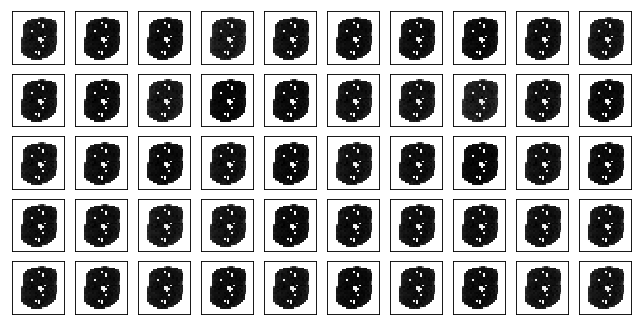

Test losses. G: -16.6910, D: -37.2025
Train Epoch: 2 [0/50000 (0%)]	Losses G: -16.6056, D: -3.9180
Train Epoch: 2 [5000/50000 (10%)]	Losses G: -8.8462, D: -51.8116
Train Epoch: 2 [10000/50000 (20%)]	Losses G: -44.7565, D: 12.6334
Train Epoch: 2 [15000/50000 (30%)]	Losses G: -31.6477, D: 5.1497
Train Epoch: 2 [20000/50000 (40%)]	Losses G: -40.3386, D: -14.1143
Train Epoch: 2 [25000/50000 (50%)]	Losses G: -59.7850, D: 20.0453
Train Epoch: 2 [30000/50000 (60%)]	Losses G: -39.2396, D: -17.8507
Train Epoch: 2 [35000/50000 (70%)]	Losses G: -30.2486, D: 2.8926
Train Epoch: 2 [40000/50000 (80%)]	Losses G: -29.4274, D: -7.8520
Train Epoch: 2 [45000/50000 (90%)]	Losses G: -37.2085, D: -5.3321
Train Epoch: 2 [50000/50000 (100%)]	Losses G: -39.4467, D: -3.4966


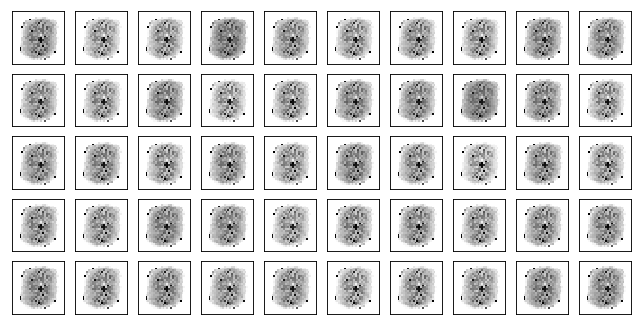

Test losses. G: -40.4618, D: -85.5303
Train Epoch: 3 [0/50000 (0%)]	Losses G: -40.5912, D: -3.8689
Train Epoch: 3 [5000/50000 (10%)]	Losses G: -69.7101, D: -7.4546
Train Epoch: 3 [10000/50000 (20%)]	Losses G: -63.2572, D: -4.7743
Train Epoch: 3 [15000/50000 (30%)]	Losses G: -59.8000, D: -5.4002
Train Epoch: 3 [20000/50000 (40%)]	Losses G: -52.1289, D: -6.5593
Train Epoch: 3 [25000/50000 (50%)]	Losses G: -46.5110, D: -4.2244
Train Epoch: 3 [30000/50000 (60%)]	Losses G: -51.4156, D: -4.5205
Train Epoch: 3 [35000/50000 (70%)]	Losses G: -48.0796, D: -5.9268
Train Epoch: 3 [40000/50000 (80%)]	Losses G: -46.6129, D: -3.9825
Train Epoch: 3 [45000/50000 (90%)]	Losses G: -49.8564, D: -5.9418
Train Epoch: 3 [50000/50000 (100%)]	Losses G: -53.5315, D: -5.3685


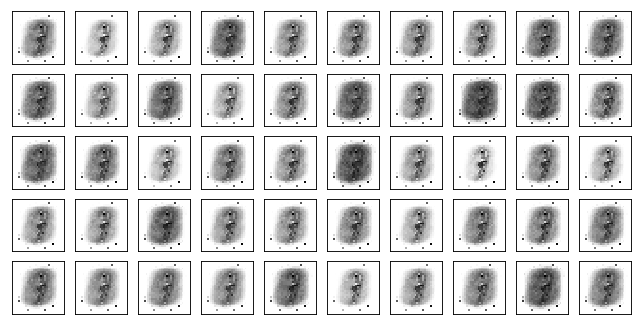

Test losses. G: -54.0728, D: -112.6322
Train Epoch: 4 [0/50000 (0%)]	Losses G: -54.0493, D: -5.2395
Train Epoch: 4 [5000/50000 (10%)]	Losses G: -54.4674, D: -5.8658
Train Epoch: 4 [10000/50000 (20%)]	Losses G: -52.5921, D: -1.5742
Train Epoch: 4 [15000/50000 (30%)]	Losses G: -47.2595, D: -2.3124
Train Epoch: 4 [20000/50000 (40%)]	Losses G: -55.4162, D: 14.1313
Train Epoch: 4 [25000/50000 (50%)]	Losses G: -51.6247, D: -4.5975
Train Epoch: 4 [30000/50000 (60%)]	Losses G: -45.4877, D: -0.0394
Train Epoch: 4 [35000/50000 (70%)]	Losses G: -49.5758, D: 0.8950
Train Epoch: 4 [40000/50000 (80%)]	Losses G: -47.5016, D: -4.6379
Train Epoch: 4 [45000/50000 (90%)]	Losses G: -51.1694, D: -7.7866
Train Epoch: 4 [50000/50000 (100%)]	Losses G: -56.1899, D: -3.6950


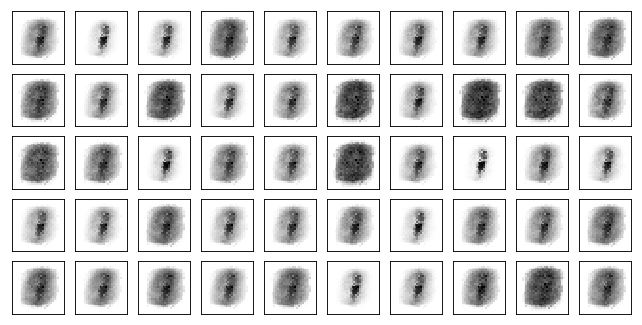

Test losses. G: -60.4762, D: -124.7543
Train Epoch: 5 [0/50000 (0%)]	Losses G: -59.0310, D: -4.7746
Train Epoch: 5 [5000/50000 (10%)]	Losses G: -56.6508, D: -2.3437
Train Epoch: 5 [10000/50000 (20%)]	Losses G: -57.6742, D: -0.4256
Train Epoch: 5 [15000/50000 (30%)]	Losses G: -57.3834, D: -1.2479
Train Epoch: 5 [20000/50000 (40%)]	Losses G: -55.1986, D: -2.8425
Train Epoch: 5 [25000/50000 (50%)]	Losses G: -58.0360, D: -3.4393
Train Epoch: 5 [30000/50000 (60%)]	Losses G: -56.5054, D: 1.5577
Train Epoch: 5 [35000/50000 (70%)]	Losses G: -46.0173, D: -1.2494
Train Epoch: 5 [40000/50000 (80%)]	Losses G: -44.5612, D: 1.8321
Train Epoch: 5 [45000/50000 (90%)]	Losses G: -51.0694, D: -0.5501
Train Epoch: 5 [50000/50000 (100%)]	Losses G: -41.1720, D: -0.1403


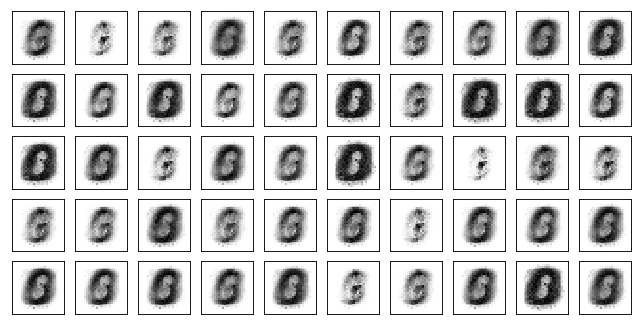

Test losses. G: -40.8957, D: -81.8010
Train Epoch: 6 [0/50000 (0%)]	Losses G: -41.0144, D: 0.6276
Train Epoch: 6 [5000/50000 (10%)]	Losses G: -46.8679, D: 0.9982
Train Epoch: 6 [10000/50000 (20%)]	Losses G: -39.8710, D: -1.1246
Train Epoch: 6 [15000/50000 (30%)]	Losses G: -40.4543, D: 2.3320
Train Epoch: 6 [20000/50000 (40%)]	Losses G: -42.4809, D: 0.5805
Train Epoch: 6 [25000/50000 (50%)]	Losses G: -40.4409, D: -1.7876
Train Epoch: 6 [30000/50000 (60%)]	Losses G: -38.4616, D: -1.7362
Train Epoch: 6 [35000/50000 (70%)]	Losses G: -34.8739, D: -1.5874
Train Epoch: 6 [40000/50000 (80%)]	Losses G: -36.2537, D: -1.3607
Train Epoch: 6 [45000/50000 (90%)]	Losses G: -34.8682, D: -1.0707
Train Epoch: 6 [50000/50000 (100%)]	Losses G: -32.4517, D: -2.8414


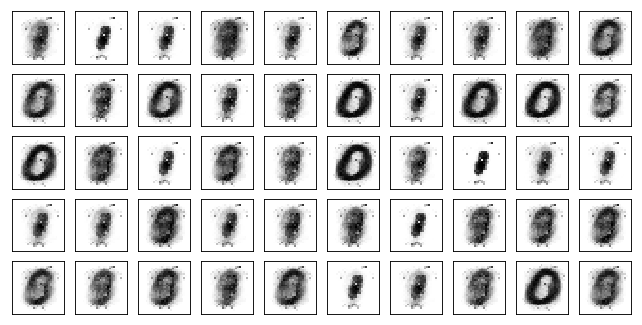

Test losses. G: -32.7080, D: -67.5876
Train Epoch: 7 [0/50000 (0%)]	Losses G: -33.1229, D: -2.4687
Train Epoch: 7 [5000/50000 (10%)]	Losses G: -32.4011, D: -1.8752
Train Epoch: 7 [10000/50000 (20%)]	Losses G: -39.6421, D: -3.0651
Train Epoch: 7 [15000/50000 (30%)]	Losses G: -39.0268, D: -2.0645
Train Epoch: 7 [20000/50000 (40%)]	Losses G: -44.8169, D: -4.2871
Train Epoch: 7 [25000/50000 (50%)]	Losses G: -46.1096, D: -2.9974
Train Epoch: 7 [30000/50000 (60%)]	Losses G: -47.8081, D: -3.3627
Train Epoch: 7 [35000/50000 (70%)]	Losses G: -50.1896, D: -3.0127
Train Epoch: 7 [40000/50000 (80%)]	Losses G: -47.6764, D: -2.6830
Train Epoch: 7 [45000/50000 (90%)]	Losses G: -50.7722, D: -3.2714
Train Epoch: 7 [50000/50000 (100%)]	Losses G: -51.1571, D: -3.0538


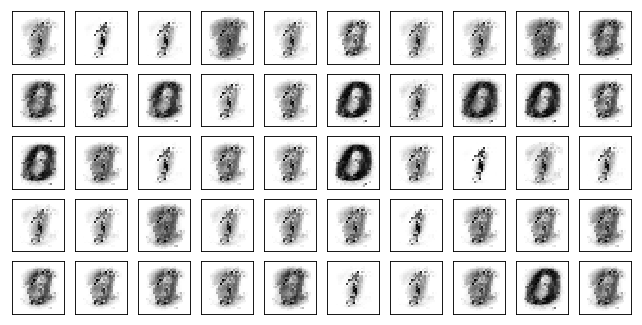

Test losses. G: -49.9975, D: -103.8607
Train Epoch: 8 [0/50000 (0%)]	Losses G: -50.2062, D: -2.9244
Train Epoch: 8 [5000/50000 (10%)]	Losses G: -48.6844, D: -3.2750
Train Epoch: 8 [10000/50000 (20%)]	Losses G: -52.0628, D: -3.1403
Train Epoch: 8 [15000/50000 (30%)]	Losses G: -50.9712, D: -3.3465
Train Epoch: 8 [20000/50000 (40%)]	Losses G: -51.8681, D: -3.0540
Train Epoch: 8 [25000/50000 (50%)]	Losses G: -48.5550, D: -3.0529
Train Epoch: 8 [30000/50000 (60%)]	Losses G: -51.5221, D: -2.7593
Train Epoch: 8 [35000/50000 (70%)]	Losses G: -50.7219, D: -2.3246
Train Epoch: 8 [40000/50000 (80%)]	Losses G: -47.9764, D: -1.9954
Train Epoch: 8 [45000/50000 (90%)]	Losses G: -45.7549, D: -1.7109
Train Epoch: 8 [50000/50000 (100%)]	Losses G: -47.6457, D: -0.5706


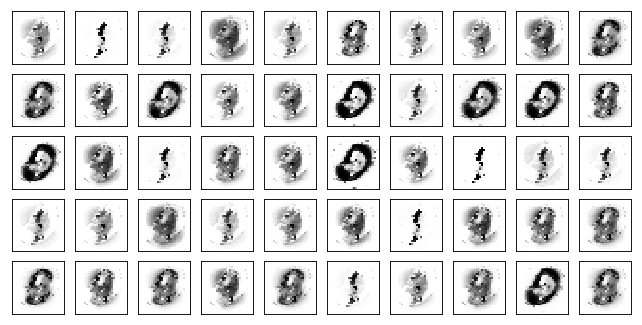

Test losses. G: -47.9007, D: -96.9888
Train Epoch: 9 [0/50000 (0%)]	Losses G: -47.5989, D: -2.1181
Train Epoch: 9 [5000/50000 (10%)]	Losses G: -48.0664, D: -2.2852
Train Epoch: 9 [10000/50000 (20%)]	Losses G: -55.0989, D: -0.3264
Train Epoch: 9 [15000/50000 (30%)]	Losses G: -51.7512, D: -2.1825
Train Epoch: 9 [20000/50000 (40%)]	Losses G: -54.3367, D: -1.4352
Train Epoch: 9 [25000/50000 (50%)]	Losses G: -53.8290, D: -3.3735
Train Epoch: 9 [30000/50000 (60%)]	Losses G: -51.6052, D: -4.6851
Train Epoch: 9 [35000/50000 (70%)]	Losses G: -45.8343, D: -2.1684
Train Epoch: 9 [40000/50000 (80%)]	Losses G: -50.6158, D: -4.7579
Train Epoch: 9 [45000/50000 (90%)]	Losses G: -42.0716, D: -2.4992
Train Epoch: 9 [50000/50000 (100%)]	Losses G: -32.7802, D: -2.4372


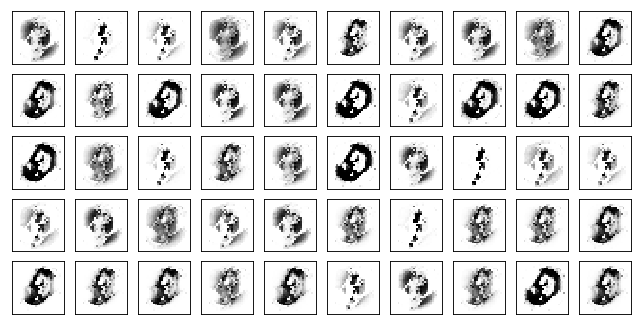

Test losses. G: -32.5000, D: -67.8592
Train Epoch: 10 [0/50000 (0%)]	Losses G: -33.2270, D: -4.6349
Train Epoch: 10 [5000/50000 (10%)]	Losses G: -15.4972, D: -3.7781
Train Epoch: 10 [10000/50000 (20%)]	Losses G: -22.1591, D: -1.7220
Train Epoch: 10 [15000/50000 (30%)]	Losses G: -13.0381, D: -4.7671
Train Epoch: 10 [20000/50000 (40%)]	Losses G: -7.2971, D: -5.4022
Train Epoch: 10 [25000/50000 (50%)]	Losses G: -7.5006, D: -12.0441
Train Epoch: 10 [30000/50000 (60%)]	Losses G: -4.8372, D: -5.1603
Train Epoch: 10 [35000/50000 (70%)]	Losses G: -8.8444, D: -6.5759
Train Epoch: 10 [40000/50000 (80%)]	Losses G: -12.2746, D: -3.0121
Train Epoch: 10 [45000/50000 (90%)]	Losses G: -7.5658, D: -5.7594
Train Epoch: 10 [50000/50000 (100%)]	Losses G: -8.4538, D: -3.3159


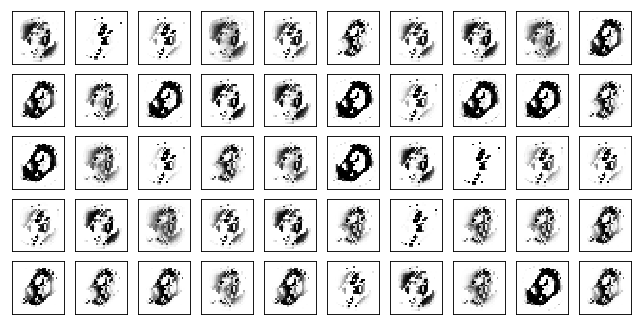

Test losses. G: -8.8508, D: -21.1119
Train Epoch: 11 [0/50000 (0%)]	Losses G: -8.0632, D: -5.3117
Train Epoch: 11 [5000/50000 (10%)]	Losses G: -9.4997, D: -3.0676
Train Epoch: 11 [10000/50000 (20%)]	Losses G: -13.7598, D: -4.4414
Train Epoch: 11 [15000/50000 (30%)]	Losses G: -11.9811, D: -5.3990
Train Epoch: 11 [20000/50000 (40%)]	Losses G: -7.0354, D: -6.1743
Train Epoch: 11 [25000/50000 (50%)]	Losses G: -17.7450, D: -5.9499
Train Epoch: 11 [30000/50000 (60%)]	Losses G: -4.6929, D: -1.3672
Train Epoch: 11 [35000/50000 (70%)]	Losses G: -7.0915, D: -7.3805
Train Epoch: 11 [40000/50000 (80%)]	Losses G: -8.6054, D: -3.7132
Train Epoch: 11 [45000/50000 (90%)]	Losses G: -13.1319, D: -5.0688
Train Epoch: 11 [50000/50000 (100%)]	Losses G: -16.5949, D: -4.9018


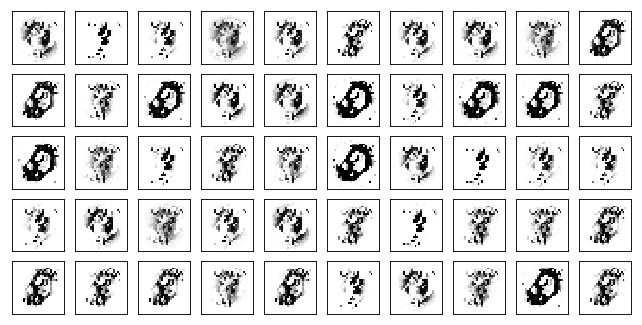

Test losses. G: -17.0474, D: -40.6712
Train Epoch: 12 [0/50000 (0%)]	Losses G: -16.6623, D: -5.7625
Train Epoch: 12 [5000/50000 (10%)]	Losses G: -14.2397, D: -1.0995
Train Epoch: 12 [10000/50000 (20%)]	Losses G: -13.1212, D: -4.8346
Train Epoch: 12 [15000/50000 (30%)]	Losses G: -12.6903, D: -3.4229
Train Epoch: 12 [20000/50000 (40%)]	Losses G: -11.5992, D: 1.4337
Train Epoch: 12 [25000/50000 (50%)]	Losses G: -11.2567, D: -5.8895
Train Epoch: 12 [30000/50000 (60%)]	Losses G: -6.8085, D: -2.2513
Train Epoch: 12 [35000/50000 (70%)]	Losses G: -18.3894, D: -6.2240
Train Epoch: 12 [40000/50000 (80%)]	Losses G: -12.2152, D: -4.3382
Train Epoch: 12 [45000/50000 (90%)]	Losses G: -8.9122, D: -4.7883
Train Epoch: 12 [50000/50000 (100%)]	Losses G: -8.5546, D: -2.3238


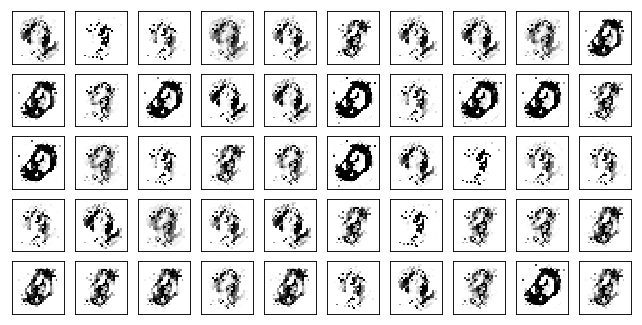

Test losses. G: -9.8973, D: -23.0625
Train Epoch: 13 [0/50000 (0%)]	Losses G: -9.8240, D: -3.4191
Train Epoch: 13 [5000/50000 (10%)]	Losses G: -5.6325, D: -4.0686
Train Epoch: 13 [10000/50000 (20%)]	Losses G: -7.3201, D: -5.7249
Train Epoch: 13 [15000/50000 (30%)]	Losses G: -0.3439, D: -2.6146
Train Epoch: 13 [20000/50000 (40%)]	Losses G: -13.9750, D: -5.7570
Train Epoch: 13 [25000/50000 (50%)]	Losses G: -4.4751, D: -5.9191
Train Epoch: 13 [30000/50000 (60%)]	Losses G: -5.6160, D: -4.8419
Train Epoch: 13 [35000/50000 (70%)]	Losses G: -4.5101, D: -5.3833
Train Epoch: 13 [40000/50000 (80%)]	Losses G: -4.7067, D: -5.9641
Train Epoch: 13 [45000/50000 (90%)]	Losses G: -7.1178, D: -6.6365
Train Epoch: 13 [50000/50000 (100%)]	Losses G: -7.8580, D: -6.0865


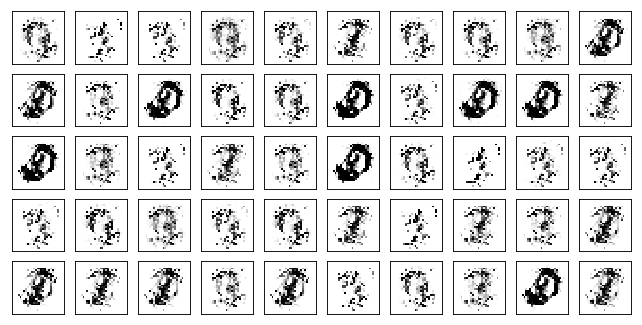

Test losses. G: -8.5709, D: -24.0596
Train Epoch: 14 [0/50000 (0%)]	Losses G: -6.6819, D: -5.9242
Train Epoch: 14 [5000/50000 (10%)]	Losses G: -4.2282, D: -5.8788
Train Epoch: 14 [10000/50000 (20%)]	Losses G: -2.3515, D: -6.0908
Train Epoch: 14 [15000/50000 (30%)]	Losses G: -5.5325, D: -5.1192
Train Epoch: 14 [20000/50000 (40%)]	Losses G: -5.2760, D: -9.4834
Train Epoch: 14 [25000/50000 (50%)]	Losses G: -4.5724, D: -4.6473
Train Epoch: 14 [30000/50000 (60%)]	Losses G: -3.9759, D: -8.2710
Train Epoch: 14 [35000/50000 (70%)]	Losses G: -3.6253, D: -7.7511
Train Epoch: 14 [40000/50000 (80%)]	Losses G: -3.2521, D: -5.6301
Train Epoch: 14 [45000/50000 (90%)]	Losses G: -9.2174, D: -7.4045
Train Epoch: 14 [50000/50000 (100%)]	Losses G: -2.4272, D: -5.4785


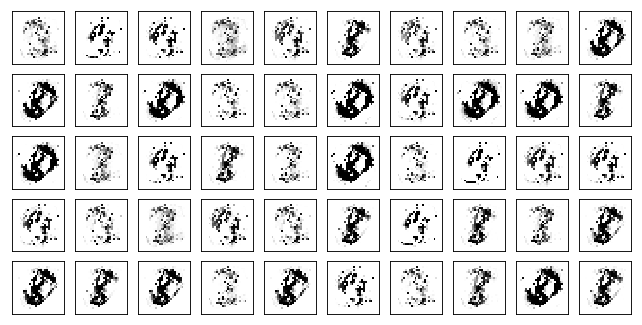

Test losses. G: -2.6496, D: -9.7761
Train Epoch: 15 [0/50000 (0%)]	Losses G: -3.4033, D: -6.6304
Train Epoch: 15 [5000/50000 (10%)]	Losses G: -12.4990, D: -6.9267
Train Epoch: 15 [10000/50000 (20%)]	Losses G: -6.7204, D: -4.2747
Train Epoch: 15 [15000/50000 (30%)]	Losses G: -6.6749, D: -7.4813
Train Epoch: 15 [20000/50000 (40%)]	Losses G: -3.2527, D: -6.7791
Train Epoch: 15 [25000/50000 (50%)]	Losses G: -5.8663, D: -6.7599
Train Epoch: 15 [30000/50000 (60%)]	Losses G: -6.0053, D: -4.9045
Train Epoch: 15 [35000/50000 (70%)]	Losses G: -9.5720, D: -6.9774
Train Epoch: 15 [40000/50000 (80%)]	Losses G: -11.1989, D: -6.0258
Train Epoch: 15 [45000/50000 (90%)]	Losses G: -7.6054, D: -7.8418
Train Epoch: 15 [50000/50000 (100%)]	Losses G: -0.8255, D: -3.6319


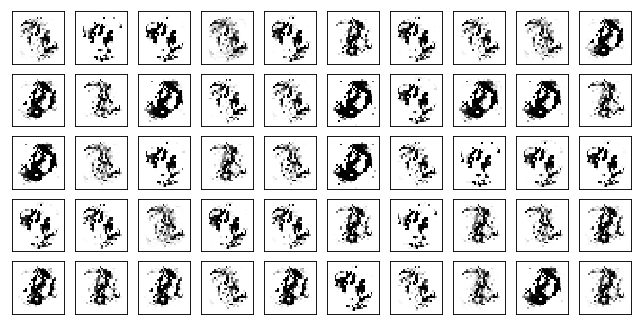

Test losses. G: -0.4503, D: -3.2250
Train Epoch: 16 [0/50000 (0%)]	Losses G: -1.1133, D: -3.1711
Train Epoch: 16 [5000/50000 (10%)]	Losses G: -6.4415, D: -5.3137
Train Epoch: 16 [10000/50000 (20%)]	Losses G: -6.1017, D: -7.8702
Train Epoch: 16 [15000/50000 (30%)]	Losses G: -4.9540, D: -5.4159
Train Epoch: 16 [20000/50000 (40%)]	Losses G: -5.8077, D: -8.1891
Train Epoch: 16 [25000/50000 (50%)]	Losses G: -9.4736, D: -5.4828
Train Epoch: 16 [30000/50000 (60%)]	Losses G: -11.8175, D: -7.8375
Train Epoch: 16 [35000/50000 (70%)]	Losses G: -5.3407, D: -2.1062
Train Epoch: 16 [40000/50000 (80%)]	Losses G: -7.7323, D: -7.2656
Train Epoch: 16 [45000/50000 (90%)]	Losses G: -7.8363, D: -7.9830
Train Epoch: 16 [50000/50000 (100%)]	Losses G: -5.6779, D: -5.6210


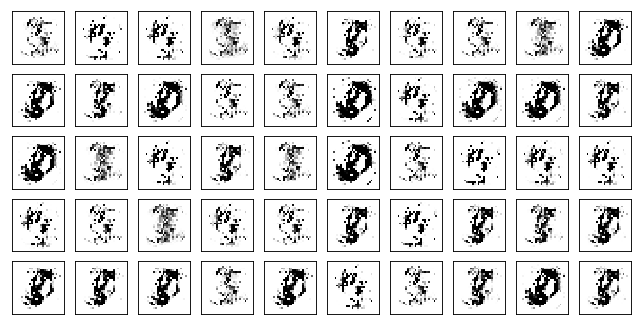

Test losses. G: -6.6989, D: -20.2395
Train Epoch: 17 [0/50000 (0%)]	Losses G: -6.5465, D: -5.9528
Train Epoch: 17 [5000/50000 (10%)]	Losses G: -6.7034, D: -5.5978
Train Epoch: 17 [10000/50000 (20%)]	Losses G: -4.3533, D: -4.9024
Train Epoch: 17 [15000/50000 (30%)]	Losses G: -3.1057, D: -6.5906
Train Epoch: 17 [20000/50000 (40%)]	Losses G: -4.9689, D: -6.3628
Train Epoch: 17 [25000/50000 (50%)]	Losses G: -12.0290, D: -8.9010
Train Epoch: 17 [30000/50000 (60%)]	Losses G: -6.1743, D: -7.2346
Train Epoch: 17 [35000/50000 (70%)]	Losses G: -1.4940, D: -3.1270
Train Epoch: 17 [40000/50000 (80%)]	Losses G: -2.8137, D: -3.9086
Train Epoch: 17 [45000/50000 (90%)]	Losses G: -4.8055, D: -2.8677
Train Epoch: 17 [50000/50000 (100%)]	Losses G: -2.1598, D: -6.4537


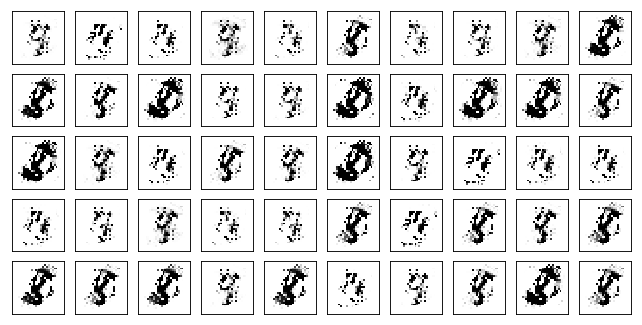

Test losses. G: -3.5356, D: -11.8381
Train Epoch: 18 [0/50000 (0%)]	Losses G: -3.2230, D: -6.6368
Train Epoch: 18 [5000/50000 (10%)]	Losses G: -3.7289, D: -9.7972
Train Epoch: 18 [10000/50000 (20%)]	Losses G: -8.1996, D: -4.8368
Train Epoch: 18 [15000/50000 (30%)]	Losses G: -18.2012, D: -5.6947
Train Epoch: 18 [20000/50000 (40%)]	Losses G: -8.1812, D: -4.9776
Train Epoch: 18 [25000/50000 (50%)]	Losses G: -7.8799, D: -5.8557
Train Epoch: 18 [30000/50000 (60%)]	Losses G: -4.9222, D: -3.4296
Train Epoch: 18 [35000/50000 (70%)]	Losses G: -9.2476, D: -7.8179
Train Epoch: 18 [40000/50000 (80%)]	Losses G: -3.7832, D: -6.5653
Train Epoch: 18 [45000/50000 (90%)]	Losses G: -7.0568, D: -7.9630
Train Epoch: 18 [50000/50000 (100%)]	Losses G: -12.1457, D: -8.0790


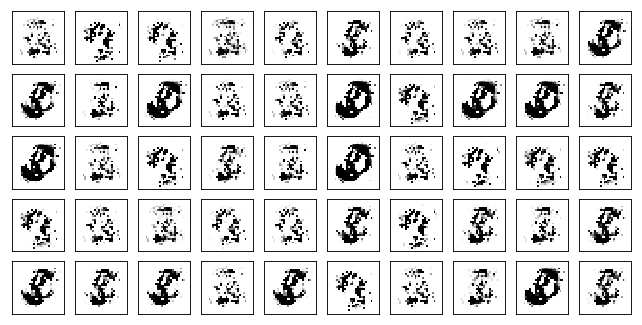

Test losses. G: -12.0041, D: -31.3175
Train Epoch: 19 [0/50000 (0%)]	Losses G: -12.9713, D: -9.8961
Train Epoch: 19 [5000/50000 (10%)]	Losses G: -6.9131, D: -4.6095
Train Epoch: 19 [10000/50000 (20%)]	Losses G: -15.4396, D: -4.8330
Train Epoch: 19 [15000/50000 (30%)]	Losses G: -2.1360, D: -2.8465
Train Epoch: 19 [20000/50000 (40%)]	Losses G: -3.2011, D: -11.4091
Train Epoch: 19 [25000/50000 (50%)]	Losses G: -3.3200, D: -5.7209
Train Epoch: 19 [30000/50000 (60%)]	Losses G: -3.0566, D: -3.2977
Train Epoch: 19 [35000/50000 (70%)]	Losses G: -3.3527, D: -8.7057
Train Epoch: 19 [40000/50000 (80%)]	Losses G: -4.8680, D: -5.3646
Train Epoch: 19 [45000/50000 (90%)]	Losses G: -7.8602, D: -7.4850
Train Epoch: 19 [50000/50000 (100%)]	Losses G: -11.4155, D: -3.9350


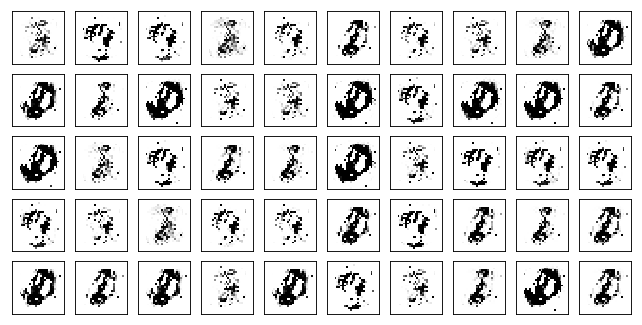

Test losses. G: -13.5241, D: -29.7342
Train Epoch: 20 [0/50000 (0%)]	Losses G: -12.6926, D: -5.0498
Train Epoch: 20 [5000/50000 (10%)]	Losses G: -14.5298, D: -7.3830
Train Epoch: 20 [10000/50000 (20%)]	Losses G: -8.6766, D: -8.9179
Train Epoch: 20 [15000/50000 (30%)]	Losses G: -1.4881, D: -3.4452
Train Epoch: 20 [20000/50000 (40%)]	Losses G: -8.6936, D: -8.9757
Train Epoch: 20 [25000/50000 (50%)]	Losses G: -6.6081, D: -3.1218
Train Epoch: 20 [30000/50000 (60%)]	Losses G: -4.8907, D: -5.6260
Train Epoch: 20 [35000/50000 (70%)]	Losses G: -4.0253, D: -8.5083
Train Epoch: 20 [40000/50000 (80%)]	Losses G: -6.1789, D: -7.0821
Train Epoch: 20 [45000/50000 (90%)]	Losses G: -3.7389, D: -0.9528
Train Epoch: 20 [50000/50000 (100%)]	Losses G: -0.7223, D: -2.7141


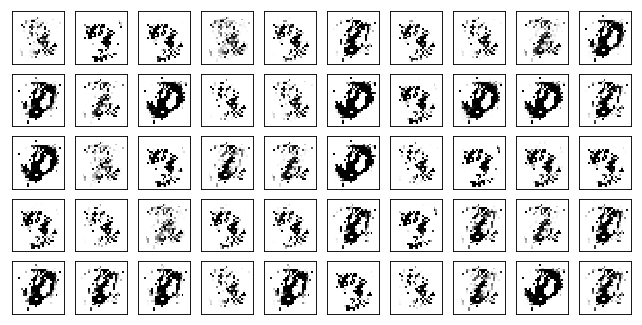

Test losses. G: -0.0440, D: -1.7446
Train Epoch: 21 [0/50000 (0%)]	Losses G: -0.1536, D: -1.3710
Train Epoch: 21 [5000/50000 (10%)]	Losses G: -16.3314, D: -4.6902
Train Epoch: 21 [10000/50000 (20%)]	Losses G: -14.7743, D: -7.6897
Train Epoch: 21 [15000/50000 (30%)]	Losses G: -3.5959, D: -7.7528
Train Epoch: 21 [20000/50000 (40%)]	Losses G: -1.3319, D: -7.0030
Train Epoch: 21 [25000/50000 (50%)]	Losses G: -3.0662, D: -4.0363
Train Epoch: 21 [30000/50000 (60%)]	Losses G: -5.7161, D: -4.3996
Train Epoch: 21 [35000/50000 (70%)]	Losses G: -18.5384, D: -3.4816
Train Epoch: 21 [40000/50000 (80%)]	Losses G: -15.2569, D: -5.8203
Train Epoch: 21 [45000/50000 (90%)]	Losses G: -4.2166, D: -11.0889
Train Epoch: 21 [50000/50000 (100%)]	Losses G: -1.0365, D: -3.3509


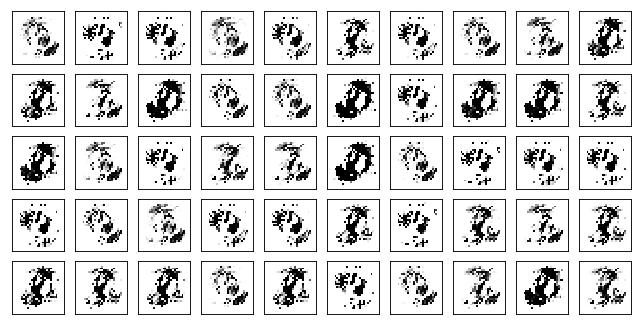

Test losses. G: -1.4668, D: -5.1392
Train Epoch: 22 [0/50000 (0%)]	Losses G: -1.0715, D: -2.4784
Train Epoch: 22 [5000/50000 (10%)]	Losses G: -4.2702, D: -5.5952
Train Epoch: 22 [10000/50000 (20%)]	Losses G: -8.3728, D: -7.0267
Train Epoch: 22 [15000/50000 (30%)]	Losses G: -3.7031, D: -8.1337
Train Epoch: 22 [20000/50000 (40%)]	Losses G: -6.3577, D: -8.5472
Train Epoch: 22 [25000/50000 (50%)]	Losses G: -9.3941, D: -5.6205
Train Epoch: 22 [30000/50000 (60%)]	Losses G: -10.6025, D: -5.9517
Train Epoch: 22 [35000/50000 (70%)]	Losses G: -7.9929, D: -7.7718
Train Epoch: 22 [40000/50000 (80%)]	Losses G: -8.6278, D: -7.3373
Train Epoch: 22 [45000/50000 (90%)]	Losses G: -9.6475, D: -6.5784
Train Epoch: 22 [50000/50000 (100%)]	Losses G: -9.7737, D: -4.6141


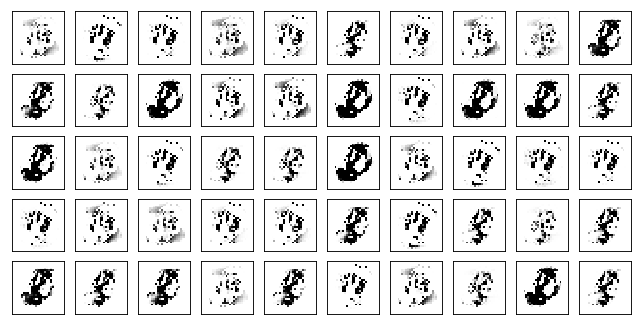

Test losses. G: -8.0356, D: -22.2669
Train Epoch: 23 [0/50000 (0%)]	Losses G: -7.6344, D: -5.6962
Train Epoch: 23 [5000/50000 (10%)]	Losses G: -5.8661, D: -6.2582
Train Epoch: 23 [10000/50000 (20%)]	Losses G: -6.3723, D: -6.9231
Train Epoch: 23 [15000/50000 (30%)]	Losses G: -9.8400, D: -5.8878
Train Epoch: 23 [20000/50000 (40%)]	Losses G: -7.0477, D: -8.1833
Train Epoch: 23 [25000/50000 (50%)]	Losses G: -4.9873, D: -5.4178
Train Epoch: 23 [30000/50000 (60%)]	Losses G: -2.8897, D: -3.1343
Train Epoch: 23 [35000/50000 (70%)]	Losses G: -7.3512, D: -7.1510
Train Epoch: 23 [40000/50000 (80%)]	Losses G: -4.1909, D: -8.2365
Train Epoch: 23 [45000/50000 (90%)]	Losses G: -0.4850, D: -0.8183
Train Epoch: 23 [50000/50000 (100%)]	Losses G: -0.2053, D: -3.2455


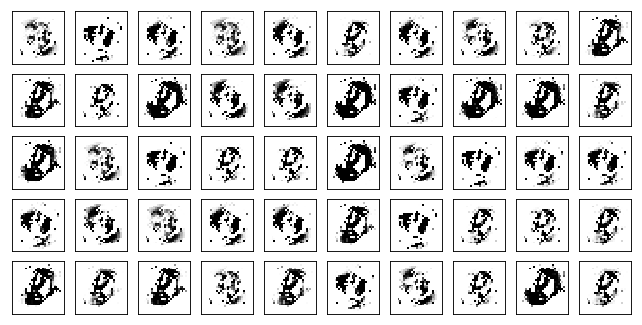

Test losses. G: 0.3626, D: -1.7343
Train Epoch: 24 [0/50000 (0%)]	Losses G: -0.5065, D: -3.4282
Train Epoch: 24 [5000/50000 (10%)]	Losses G: -5.0286, D: -8.2900
Train Epoch: 24 [10000/50000 (20%)]	Losses G: -5.8542, D: -5.8432
Train Epoch: 24 [15000/50000 (30%)]	Losses G: -5.0988, D: -5.9925
Train Epoch: 24 [20000/50000 (40%)]	Losses G: -6.2131, D: -6.0167
Train Epoch: 24 [25000/50000 (50%)]	Losses G: -6.4190, D: -10.9367
Train Epoch: 24 [30000/50000 (60%)]	Losses G: -6.4014, D: -5.8745
Train Epoch: 24 [35000/50000 (70%)]	Losses G: -0.7479, D: -3.6981
Train Epoch: 24 [40000/50000 (80%)]	Losses G: -12.0883, D: -10.4781
Train Epoch: 24 [45000/50000 (90%)]	Losses G: -4.0757, D: -3.2658
Train Epoch: 24 [50000/50000 (100%)]	Losses G: -4.2269, D: -6.3519


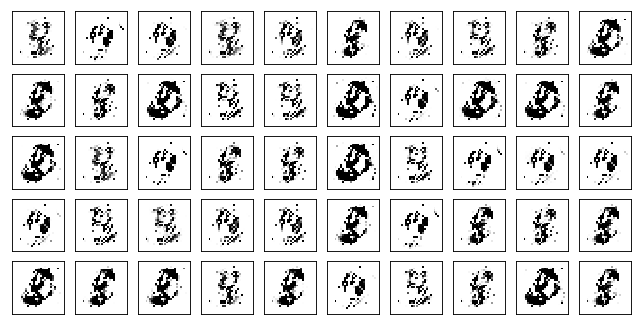

Test losses. G: -3.8264, D: -13.9598
Train Epoch: 25 [0/50000 (0%)]	Losses G: -4.1930, D: -8.6430
Train Epoch: 25 [5000/50000 (10%)]	Losses G: -3.7768, D: -7.2717
Train Epoch: 25 [10000/50000 (20%)]	Losses G: -6.6085, D: -10.9980
Train Epoch: 25 [15000/50000 (30%)]	Losses G: -0.6179, D: -2.7468
Train Epoch: 25 [20000/50000 (40%)]	Losses G: -7.8665, D: -3.6830
Train Epoch: 25 [25000/50000 (50%)]	Losses G: -6.8452, D: -6.7966
Train Epoch: 25 [30000/50000 (60%)]	Losses G: -4.6023, D: -5.8135
Train Epoch: 25 [35000/50000 (70%)]	Losses G: -13.2923, D: -9.2730
Train Epoch: 25 [40000/50000 (80%)]	Losses G: -2.4301, D: -6.8789
Train Epoch: 25 [45000/50000 (90%)]	Losses G: -9.5954, D: -6.1162
Train Epoch: 25 [50000/50000 (100%)]	Losses G: -2.2293, D: -5.7377


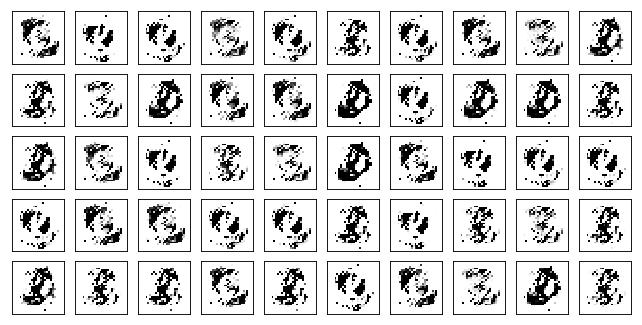

Test losses. G: -1.9382, D: -7.2515
Train Epoch: 26 [0/50000 (0%)]	Losses G: -1.6160, D: -4.2869
Train Epoch: 26 [5000/50000 (10%)]	Losses G: -25.1910, D: -5.8387
Train Epoch: 26 [10000/50000 (20%)]	Losses G: -30.0668, D: -9.7310
Train Epoch: 26 [15000/50000 (30%)]	Losses G: -36.8519, D: -4.5433
Train Epoch: 26 [20000/50000 (40%)]	Losses G: -17.7528, D: -11.1335
Train Epoch: 26 [25000/50000 (50%)]	Losses G: -4.7702, D: -4.4711
Train Epoch: 26 [30000/50000 (60%)]	Losses G: -14.0573, D: -9.8682
Train Epoch: 26 [35000/50000 (70%)]	Losses G: -2.7527, D: -6.6066
Train Epoch: 26 [40000/50000 (80%)]	Losses G: -8.7218, D: -6.1775
Train Epoch: 26 [45000/50000 (90%)]	Losses G: -7.9114, D: -6.8474
Train Epoch: 26 [50000/50000 (100%)]	Losses G: -4.8465, D: -3.4539


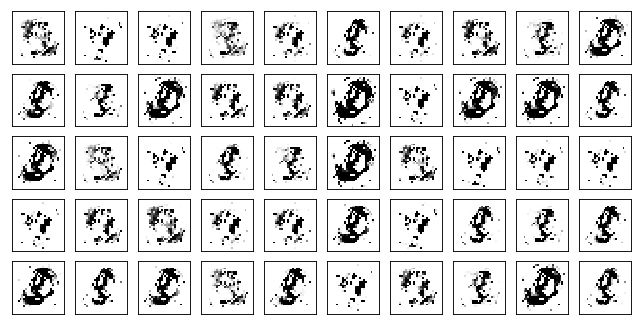

Test losses. G: -4.2813, D: -12.9393
Train Epoch: 27 [0/50000 (0%)]	Losses G: -4.5029, D: -4.5968
Train Epoch: 27 [5000/50000 (10%)]	Losses G: -5.1309, D: -6.3065
Train Epoch: 27 [10000/50000 (20%)]	Losses G: -6.1684, D: -8.0369
Train Epoch: 27 [15000/50000 (30%)]	Losses G: -1.0659, D: -3.5457
Train Epoch: 27 [20000/50000 (40%)]	Losses G: -3.0572, D: -8.4572
Train Epoch: 27 [25000/50000 (50%)]	Losses G: -2.5612, D: -8.0733
Train Epoch: 27 [30000/50000 (60%)]	Losses G: -1.9727, D: -6.2559
Train Epoch: 27 [35000/50000 (70%)]	Losses G: -1.8720, D: -6.6949
Train Epoch: 27 [40000/50000 (80%)]	Losses G: -2.0254, D: -8.8128
Train Epoch: 27 [45000/50000 (90%)]	Losses G: -2.2469, D: -5.5655
Train Epoch: 27 [50000/50000 (100%)]	Losses G: -3.2345, D: -4.2327


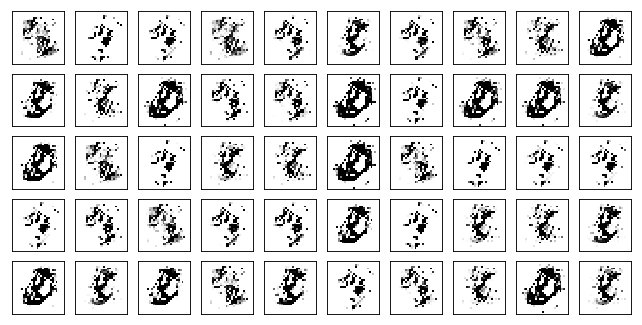

Test losses. G: -2.7525, D: -11.1050
Train Epoch: 28 [0/50000 (0%)]	Losses G: -3.0576, D: -5.8477
Train Epoch: 28 [5000/50000 (10%)]	Losses G: -4.8443, D: -6.5305
Train Epoch: 28 [10000/50000 (20%)]	Losses G: -3.1717, D: -9.1557
Train Epoch: 28 [15000/50000 (30%)]	Losses G: -1.4825, D: -5.5944
Train Epoch: 28 [20000/50000 (40%)]	Losses G: -2.8548, D: -8.9044
Train Epoch: 28 [25000/50000 (50%)]	Losses G: -3.8277, D: -7.5760
Train Epoch: 28 [30000/50000 (60%)]	Losses G: -4.6747, D: -7.5279
Train Epoch: 28 [35000/50000 (70%)]	Losses G: -2.3059, D: -9.0875
Train Epoch: 28 [40000/50000 (80%)]	Losses G: -1.3654, D: -4.9991
Train Epoch: 28 [45000/50000 (90%)]	Losses G: -2.8055, D: -9.4342
Train Epoch: 28 [50000/50000 (100%)]	Losses G: -5.9296, D: -7.8812


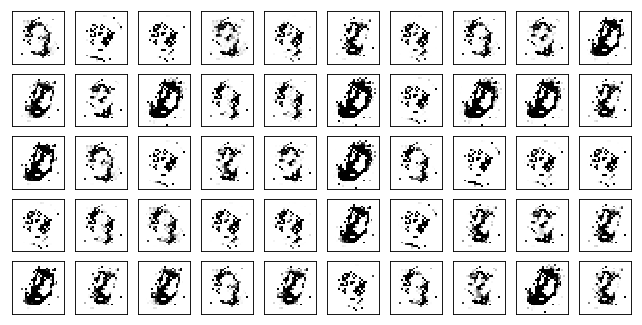

Test losses. G: -5.6417, D: -18.4688
Train Epoch: 29 [0/50000 (0%)]	Losses G: -4.5713, D: -5.3929
Train Epoch: 29 [5000/50000 (10%)]	Losses G: -1.1579, D: -4.3681
Train Epoch: 29 [10000/50000 (20%)]	Losses G: -5.4360, D: -8.5240
Train Epoch: 29 [15000/50000 (30%)]	Losses G: -2.1854, D: -7.8490
Train Epoch: 29 [20000/50000 (40%)]	Losses G: -10.4857, D: -7.8806
Train Epoch: 29 [25000/50000 (50%)]	Losses G: -18.1379, D: -17.3167
Train Epoch: 29 [30000/50000 (60%)]	Losses G: -11.3132, D: -25.5243
Train Epoch: 29 [35000/50000 (70%)]	Losses G: -0.2502, D: 0.5635
Train Epoch: 29 [40000/50000 (80%)]	Losses G: 0.5577, D: 0.2059
Train Epoch: 29 [45000/50000 (90%)]	Losses G: -5.9452, D: -4.3878
Train Epoch: 29 [50000/50000 (100%)]	Losses G: -31.2642, D: -0.8045


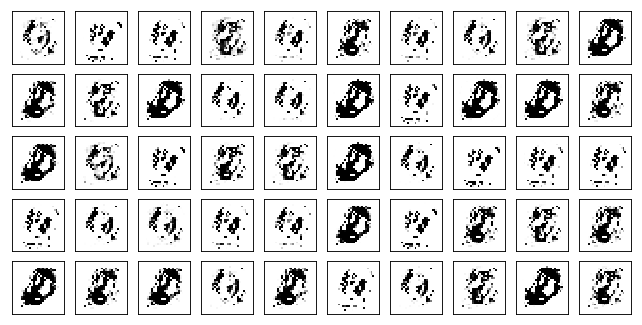

Test losses. G: -33.1565, D: -70.4838
Train Epoch: 30 [0/50000 (0%)]	Losses G: -31.7633, D: -1.7292
Train Epoch: 30 [5000/50000 (10%)]	Losses G: -26.6089, D: -8.8642
Train Epoch: 30 [10000/50000 (20%)]	Losses G: -24.1762, D: -3.5450
Train Epoch: 30 [15000/50000 (30%)]	Losses G: -25.0710, D: -8.5945
Train Epoch: 30 [20000/50000 (40%)]	Losses G: -26.5709, D: -3.6200
Train Epoch: 30 [25000/50000 (50%)]	Losses G: -26.7149, D: -2.6464
Train Epoch: 30 [30000/50000 (60%)]	Losses G: -30.8173, D: -5.4122
Train Epoch: 30 [35000/50000 (70%)]	Losses G: -30.7461, D: -3.8819
Train Epoch: 30 [40000/50000 (80%)]	Losses G: -8.9751, D: -6.5983
Train Epoch: 30 [45000/50000 (90%)]	Losses G: -8.0304, D: -8.5000
Train Epoch: 30 [50000/50000 (100%)]	Losses G: -4.3317, D: -6.0038


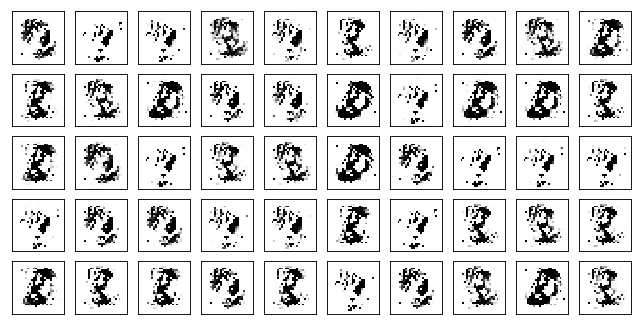

Test losses. G: -4.9666, D: -16.1676


In [67]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test_wg(G, D, valid_loader, epoch, test_log)